In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

In [2]:
# Since our pipeline is not up and running yet, let's just import the traintestsplit function
from python_scripts.traintestsplit import custom_train_test_split

In [3]:
features = ['GRADE','AGE','SKILL','NUMOFF','POS','HEIGHT_IN','WEIGHT_LBS','COLLDIST_MI','INSTA_LONG','TWIT_LONG','TIK_LONG','TOT_FOL','RECRUIT_YEAR','EXP_MONTHS','EXP_YEARS','ClassificationCode', 'REV_MEN', 'EXP_MEN']

In [4]:
# Read in the cleaned CSV  for football
df_bb = pd.read_csv("cleaned_files/basketball_clean_supervised.csv")
df_fb = pd.read_csv("cleaned_files/football_clean_supervised.csv")
df_bb = df_bb.drop(columns=['Unnamed: 0', 'NAME','STARCOLL','SPORT','institution_name_short'])
df_fb = df_fb.drop(columns=['Unnamed: 0', 'NAME','STARCOLL','SPORT','institution_name_short'])
print("Basketball dataset shape: {}, Football dataset shape: {}".format(df_bb.shape,df_fb.shape))

df_bb.describe()

Basketball dataset shape: (137, 19), Football dataset shape: (1263, 19)


,GRADE,AGE,SKILL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,COLLDIST_MI,NILVAL_LONG_USD,INSTA_LONG,TWIT_LONG,TIK_LONG,TOT_FOL,RECRUIT_YEAR,EXP_MONTHS,EXP_YEARS,ClassificationCode,REV_MEN,EXP_MEN
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02,1.370000e+02,137.000000,1.370000e+02,1.370000e+02,137.000000,137.000000,137.000000,137.000000,1.370000e+02,1.370000e+02
mean,1.226277,17.267153,97.230584,16.802920,3.175182,77.715328,192.080292,799.569343,2.663796e+05,7.560312e+04,3063.248175,7.253988e+04,7.560312e+04,2023.751825,3.240876,0.278672,1.109489,1.866788e+07,1.383730e+07
std,1.689033,2.203449,1.604059,6.439583,1.621990,3.074920,20.836216,1553.413276,5.394494e+05,5.281315e+05,4588.230084,5.261497e+05,5.281315e+05,1.304861,6.954184,0.584755,0.448508,9.808841e+06,5.919632e+06
min,0.000000,-2.000000,92.480000,1.000000,1.000000,72.000000,150.000000,0.000000,6.000000e+04,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2021.000000,0.000000,0.000000,1.000000,1.892777e+06,1.892777e+06
25%,0.000000,16.000000,96.440000,13.000000,2.000000,76.000000,180.000000,95.000000,9.000000e+04,1.100000e+03,762.000000,0.000000e+00,1.100000e+03,2023.000000,0.000000,0.000000,1.000000,1.201026e+07,9.849325e+06
50%,0.000000,17.000000,97.310000,17.000000,3.000000,77.000000,190.000000,315.000000,1.450000e+05,2.424000e+03,1900.000000,0.000000e+00,2.424000e+03,2024.000000,0.000000,0.000000,1.000000,1.698733e+07,1.193479e+07
75%,2.000000,19.000000,98.500000,22.000000,4.000000,80.000000,205.000000,682.000000,2.880000e+05,8.500000e+03,3300.000000,2.800000e+03,8.500000e+03,2025.000000,2.000000,0.186301,1.000000,2.357579e+07,1.586767e+07
max,6.000000,20.000000,99.890000,25.000000,7.000000,86.000000,255.000000,9625.000000,6.100000e+06,5.824000e+06,36000.000000,5.800000e+06,5.824000e+06,2026.000000,26.000000,2.186301,3.000000,4.510854e+07,2.801989e+07


In [5]:
# Split both dataset into Train, Test, and Validation sets

X_train_bb, y_train_bb, X_valid_bb, y_valid_bb, X_test_bb, y_test_bb = custom_train_test_split(df_bb)
X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = custom_train_test_split(df_fb)

print(X_train_bb.shape, X_test_bb.shape, X_valid_bb.shape)
print(X_train_fb.shape, X_test_fb.shape, X_valid_fb.shape)



(80, 19) (42, 19) (15, 19)
(751, 19) (379, 19) (133, 19)


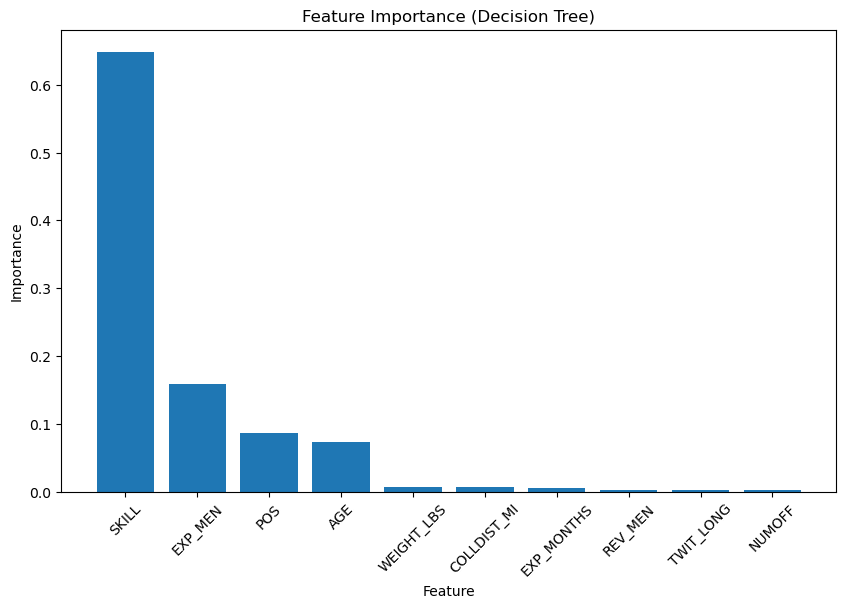

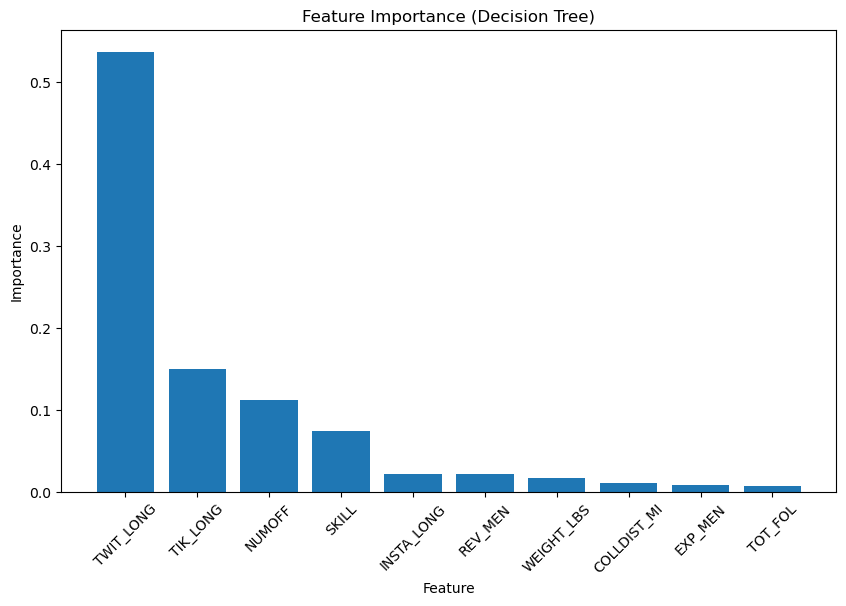

Selected Features for Dataset bb: ['SKILL', 'EXP_MEN', 'POS', 'AGE', 'WEIGHT_LBS', 'COLLDIST_MI', 'EXP_MONTHS', 'REV_MEN', 'TWIT_LONG', 'NUMOFF']
Selected Features for Dataset fb: ['TWIT_LONG', 'TIK_LONG', 'NUMOFF', 'SKILL', 'INSTA_LONG', 'REV_MEN', 'WEIGHT_LBS', 'COLLDIST_MI', 'EXP_MEN', 'TOT_FOL']


In [6]:
def feature_selection_tree_importance(X, y, features, n_features=5):
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create a DecisionTreeRegressor and fit it
    model = DecisionTreeRegressor()
    model.fit(X_scaled, y)

    # Get feature importances
    importances = model.feature_importances_

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(importances)[::-1]
    #print([features[i] for i in sorted_idx[:n_features]])
    plt.bar(range(n_features), importances[sorted_idx][:n_features], align="center")
    plt.xticks(range(n_features), [features[i] for i in sorted_idx[:n_features]], rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance (Decision Tree)')
    plt.show()

    selected_features = [features[i] for i in sorted_idx[:n_features]]

    return selected_features

# Call the function for both datasets
selected_features_bb = feature_selection_tree_importance(X_train_bb, y_train_bb, features,10)
selected_features_fb = feature_selection_tree_importance(X_train_fb, y_train_fb, features,10)

print("Selected Features for Dataset bb:", selected_features_bb)
print("Selected Features for Dataset fb:", selected_features_fb)

In [7]:
def dummy_reg(X_train,y_train,X_test,y_test):

    mean_dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)
    y_pred = mean_dummy.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

In [8]:
mse_bb, r2_bb = dummy_reg(X_train_bb,y_train_bb,X_test_bb,y_test_bb)
mse_fb, r2_fb = dummy_reg(X_train_fb,y_train_fb,X_test_fb,y_test_fb)
print("Mean squared error (dummy): {},r2_score (dummy): {}".format(mse_bb, r2_bb))
print("Mean squared error (dummy): {},r2_score (dummy): {}".format(mse_fb, r2_fb))


Mean squared error (dummy): 845018903787.2024,r2_score (dummy): -0.01688588932944035
Mean squared error (dummy): 23282564882.664856,r2_score (dummy): -0.005475359478686492


In [10]:
# Build a baseline random forest regressor
def Ran_For_Reg(X_train, y_train, X_test, y_test, random_state=0):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    rf = RandomForestRegressor(random_state=random_state)
    rf.fit(X_scaled, y_train.values)
    #y_pred = rf.predict(scaler.transform(X_test))
    score_ = rf.score(scaler.transform(X_test), y_test)
    return rf, score_

In [11]:

rf_bb, r2_score_bb = Ran_For_Reg(X_train_bb, y_train_bb, X_test_bb, y_test_bb)
rf_fb, r2_score_fb = Ran_For_Reg(X_train_fb, y_train_fb, X_test_fb, y_test_fb)
print("R2 Score: {}".format(r2_score_bb))
print("R2 Score: {}".format(r2_score_fb))

R2 Score: -0.006434493698167731
R2 Score: 0.3164160104512598


In [12]:
def grid_search(X_train,y_train,X_test,y_test):

    grid = { 
        'n_estimators': [100,200,300,400,500],
        'max_features': [3,4,5,6,7],
        'max_depth' : [3,4,5,6,7]
    }
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    rf = RandomForestRegressor(random_state=0)
    grid_rf = GridSearchCV(rf,param_grid=grid,cv=3)
    model_grid = grid_rf.fit(X_scaled,y_train)

    rf_best = model_grid.best_estimator_
    y_pred_test = rf_best.predict(scaler.transform(X_test))

    # Calculate performance metrics
    rf_dict = {'Model':'Random Forest Regressor',
          'R^2':r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MSE':mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(mean_squared_error(y_test, y_pred_test))}

    # Display model performance metrics
    rf_reg_metrics = pd.DataFrame.from_dict(rf_dict, orient = 'index').T

    print(rf_best)
    
    return rf_reg_metrics


In [13]:
bb_metrics = grid_search(X_train_bb,y_train_bb,X_valid_bb,y_valid_bb)
fb_metrics = grid_search(X_train_fb,y_train_fb,X_valid_fb,y_valid_fb)
print(bb_metrics)
print(fb_metrics)

RandomForestRegressor(max_depth=7, max_features=7, random_state=0)
RandomForestRegressor(max_depth=6, max_features=4, n_estimators=300,
                      random_state=0)
                     Model       R^2 Adjusted R^2                 MSE  \
0  Random Forest Regressor  0.100082      3.51977  80501561850.816849   

            RMSE  
0  283727.971569  
                     Model      R^2 Adjusted R^2                MSE  \
0  Random Forest Regressor  0.67325      0.61831  3155663454.051392   

           RMSE  
0  56175.292203  
